# Нейронные сети с PyTorch

Сети глубокого обучения, как правило, имеют множество слоев, до десятков или даже сотен, и именно от этого происходит термин "глубокий". Вы можете построить одну из таких глубоких сетей, используя только матрицы весов, как мы делали в предыдущем блокноте, но, как правило, это очень неудобно и сложно для реализации. PyTorch имеет удобный модуль `nn`, который позволяет эффективно строить большие нейронные сети.

In [1]:
# Импорт необходимых пакетов

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

Теперь мы собираемся построить более крупную сеть, которая сможет решить (ранее) сложную задачу по распознаванию текста на изображении. Будем использовать набор данных MNIST, который состоит из черно-белых рукописных цифр. Каждое изображение имеет размер 28x28 пикселей (см. примеры ниже).

<img src='assets/mnist.png'>

Наша цель — построить нейронную сеть, которая сможет взять одно из этих изображений и предсказать цифру на нем.

Сначала нужно получить этот набор данных. Он предоставляется через пакет `torchvision`. Код ниже загрузит набор данных MNIST, а затем создаст обучающие и тестовые наборы данных. Более детально этапы загрузки разберем в дальнейшем.

In [2]:
# Наборы данных MNIST размещены на yann.lecun.com, который переместился под защиту CloudFlare
# Запустите этот скрипт, чтобы сделать возможной загрузку этого набора данных
# Ссылка: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
### Запустите эту ячейку

from torchvision import datasets, transforms

# Определим преобразование для нормализации данных
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Загрузим обучающие данные
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

c:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:06<00:00, 1514681.57it/s]


Extracting C:\Users\user1/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\user1/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 176575.18it/s]


Extracting C:\Users\user1/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\user1/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 874751.86it/s] 


Extracting C:\Users\user1/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\user1/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 910115.08it/s]

Extracting C:\Users\user1/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\user1/.pytorch/MNIST_data/MNIST\raw



Мы загрузили обучающие данные в `trainloader` и сделали итератор с помощью `iter(trainloader)`. Позже мы будем использовать этот объект для перебора набора данных для обучения, например,

```python
for image, label in trainloader:
    ## делаем что-то с изображениями и метками
```

Объект `trainloader` создан с размером пакета (batch size) 64 и `shuffle=True`. Размер пакета (batch size) — это количество изображений, которые мы получаем за одну итерацию из загрузчика данных и передаем через нашу сеть, набор изображений - *пакет* (batch). А `shuffle=True` указывает на то, чтобы перемешивать набор данных каждый раз, когда мы начинаем снова проходить через загрузчик данных. Здесь берется первый пакет, чтобы мы могли проверить данные. Мы можем увидеть ниже, что `images` — это просто тензор с размером `(64, 1, 28, 28)`. Итак, 64 изображения на пакет, 1 цветовой канал и изображения размером 28x28.

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Вот как выглядит одно из изображений.

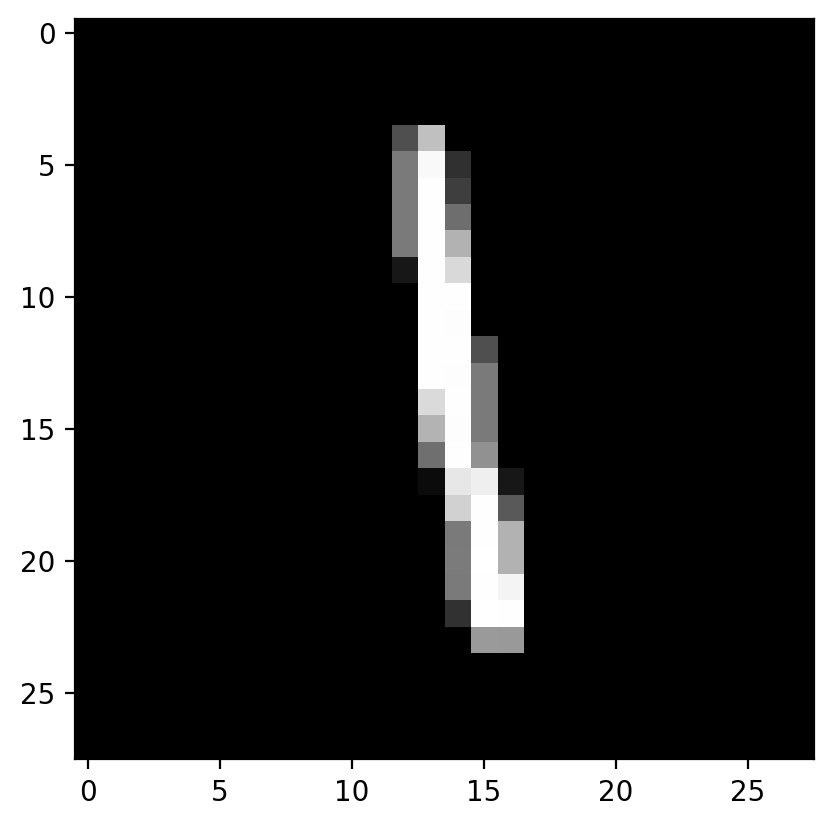

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')
plt.show()

Сначала давайте попытаемся построить простую сеть для этого набора данных, используя матрицы весов и матричные умножения. Увидим, как это сделать, используя модуль `nn` в PyTorch, который предоставляет удобный и мощный метод для определения архитектур сети.

Сети, которые вы видели до сих пор, называются *полносвязными* (fully-connected) или *плотными* (dense) сетями. Каждый узел в одном слое соединен с каждым узлом в следующем слое. В полносвязных сетях на вход каждого слоя должен поступать одномерный вектор (который можно сложить в 2D тензор как набор нескольких примеров). Однако наши изображения являются 2D тензорами размером 28x28, поэтому нужно преобразовать их в 1D векторы. Если говорить о размерах, нам нужно преобразовать пакет изображений с формой `(64, 1, 28, 28)` в форму `(64, 784)`, где 784 — это 28*28. Это обычно называется *разворачиванием* (flattening), мы разворачиваем 2D изображения в 1D векторы.

Ранее вы построили сеть с одной выходным узлом. Здесь нам нужно 10 выходных узлов, по одному для каждой цифры. Мы хотим, чтобы наша сеть предсказывала цифру, показанную на изображении, поэтому будем вычислять вероятности того, что изображение соответствует любой одной цифре или классу. Это в конечном счете представляет собой дискретное распределение вероятностей по классам (цифрам), которое говорит нам о наиболее вероятном классе для изображения. Это означает, что нам нужно 10 выходов для 10 классов (цифр). Мы увидим, как преобразовать выходные данные сети в распределение вероятностей дальше.

> **Упражнение:** Разверните пакет изображений `images`. Затем постройте многослойную сеть с 784 входными узлами, 256 скрытыми узлами и 10 выходными узлами, используя случайные тензоры для весов и смещений. Пока используйте сигмоидную активацию для скрытого слоя. Оставьте выходной слой без активации, мы добавим один слой, который даст нам распределение вероятностей в дальнейшем.

In [ ]:
def sigmoid(z):
    return 1 / (1+torch.exp(-z))

In [80]:
## TODO
X = images.view((images.shape[0],-1))
W1 = torch.randn((X.shape[1],256))
B1 = torch.randn((1,256))
A1 = sigmoid(torch.matmul(X,W1) + B1)
W2 = torch.randn((A1.shape[1],10))
B2 = torch.randn((1,10))
out = sigmoid(torch.matmul(A1,W2) + B2)

Теперь у нас есть 10 выходов для нашей сети. Мы хотим передать изображение в нашу сеть и получить распределение вероятностей по классам, которое скажет нам, к какому классу принадлежит изображение. Что-то вроде этого:
<img src='assets/image_distribution.png' width=500px>

Здесь мы видим, что вероятность для каждого класса примерно одинакова. Это картина соответствует необученной сети, она еще не видела данных, поэтому возвращает равномерное распределение с одинаковыми вероятностями для каждого класса.

Чтобы вычислить распределение вероятностей, мы часто используем [**softmax** функцию](https://en.wikipedia.org/wiki/Softmax_function). Математически эта функция выглядит как:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

Эта функция сжимает каждое входное значение $x_i$ в диапазон от 0 до 1 и нормализует значения, чтобы дать вам правильное распределение вероятностей, где вероятности в сумме составляют единицу.

> **Упражнение:** Реализуйте функцию `softmax`, которая выполняет вычисление softmax и возвращает распределения вероятностей для каждого примера в пакете. Обратите внимание, что вам нужно будет уделить внимание размерностям при выполнении этого задания. Если у вас есть тензор `a` с формой `(64, 10)` и тензор `b` с формой `(64,)`, выполнение `a/b` приведет к ошибке, потому что PyTorch попытается выполнить деление по столбцам (broadcasting), но вы получите несоответствие размеров. Каждый из 64 примеров вы хотите делить только на одно значение, сумму в знаменателе. Поэтому вам нужно, чтобы `b` имел форму `(64, 1)`. Таким образом, PyTorch разделит 10 значений в каждой строке `a` на одно значение в каждой строке `b`. Также обратите внимание на то, как вы берете сумму. Вам нужно будет задать ключевое слово `dim` в `torch.sum`. Установка `dim=0` берет сумму по строкам, в то время как `dim=1` берет сумму по столбцам.

In [82]:
## TODO
def softmax(x):
    e = torch.exp(x)
    return e / torch.sum(e,dim=1).view(e.shape[0],1)
    # реализуйте функцию

# Переменная out здесь - выход вашей сети из прошлого упражнения с формой (64,10)
probabilities = softmax(out)

# Имеет ли probabilities правильную форму? Должно быть (64, 10)
print(probabilities.shape)
# Сумма равна 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Построение сетей с PyTorch

PyTorch предоставляет модуль `nn`, который упрощает построение сетей. Покажем, как построить такую же сеть, как выше, с 784 входами, 256 скрытыми узлами, 10 выходными узлами и выходом softmax.

In [83]:
from torch import nn

In [84]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Линейное преобразование от входов к скрытому слою
        self.hidden = nn.Linear(784, 256)
        # Выходной слой, 10 узлов - по одному для каждой цифры
        self.output = nn.Linear(256, 10)
        
        # Определим сигмоидную функцию активации и softmax выход
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Пропускаем входной тензор через каждую из наших операций
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Давайте разберем это по частям.

```python
class Network(nn.Module):
```

Здесь мы наследуемся от `nn.Module`. Вместе с `super().__init__()` это создает класс, который отслеживает архитектуру и предоставляет множество полезных методов и атрибутов. Наследование от `nn.Module` обязательно при создании класса для вашей сети. Имя самого класса может быть любым.

```python
self.hidden = nn.Linear(784, 256)
```

Эта строка создает модуль для линейного преобразования, $x\mathbf{W} + b$, с 784 входами и 256 выходами и присваивает его `self.hidden`. Модуль автоматически создает тензоры весов и смещений, которые мы будем использовать в методе `forward`. Вы можете получить доступ к тензорам весов и смещений после создания сети (`net`) с помощью `net.hidden.weight` и `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Аналогично, это создает другое линейное преобразование с 256 входами и 10 выходами.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Здесь определены операции для сигмоидальной активации и выхода softmax. Установка `dim=1` в `nn.Softmax(dim=1)` вычисляет softmax по столбцам.

```python
def forward(self, x):
```

Сети PyTorch, созданные с помощью `nn.Module`, должны иметь определенный метод `forward`. Он принимает вектор `x` и пропускает его через операции, которые вы определили в методе `__init__`.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Здесь входной тензор `x` пропускается через каждую операцию и переназначается в `x`. Мы видим, что входной тензор проходит через скрытый слой, затем через сигмоидальную функцию, затем через выходной слой и, наконец, через функцию softmax. Неважно, как вы назвали переменные здесь, главное, чтобы входы и выходы операций соответствовали архитектуре сети, которую вы хотите построить. Порядок, в котором вы определяете элементы в методе `__init__`, не имеет значения, но вам нужно правильно упорядочить операции в методе `forward`.

Теперь мы можем создать объект `Network`.

In [85]:
# Создадим сеть и посмотрим на ее текстовое представление
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

Вы можете определить сеть немного более лаконично и ясно, используя модуль `torch.nn.functional`. Обычно мы импортируем этот модуль как `F`, `import torch.nn.functional as F`.

In [86]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Линейное преобразование от входов к скрытому слою
        self.hidden = nn.Linear(784, 256)
        # Выходной слой, 10 выходов - по одному для каждой цифры
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Скрытый слой с сигмоидной функцией активации
        x = F.sigmoid(self.hidden(x))
        # Выходной слой с активацией softmax
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Функции активации

До сих пор мы смотрели только на сигмоиду и softmax в качестве функций активации, но в общем случае любую функцию можно использовать в качестве активационной функции. Единственное требование состоит в том, что для того чтобы сеть могла аппроксимировать нелинейную функцию, активационные функции должны быть нелинейными. Вот еще несколько примеров распространенных функций активации: Tanh (гиперболический тангенс), и ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

На практике функция ReLU используется крайне часто в качестве функции активации для скрытых слоев.

### Постройте сеть самостоятельно

<img src="assets/mlp_mnist.png" width=600px>

> **Упражнение:** Создайте сеть с 784 входными узлами, скрытым слоем с 128 узлами и активацией ReLU, затем скрытым слоем с 64 узлами и активацией ReLU, и, наконец, выходным слоем с активацией softmax, как показано выше. Вы можете использовать активацию ReLU с модулем `nn.ReLU` или функцией `F.relu`.

Хорошей практикой является именование слоев по их типу, например, 'fc', чтобы обозначить полносвязный слой. Когда вы будете писать свое решение, используйте `fc1`, `fc2` и `fc3` в качестве имен ваших слоев.

In [93]:
## TODO
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x
    
model = NN()

### Инициализация весов и смещений

Веса и смещения автоматически инициализируются для вас, но вы можете настроить, как они инициализируются. Веса и смещения — это тензоры, связанные с определенным слоем, вы можете получить к ним доступ с помощью `model.fc1.weight` например.

In [94]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0198,  0.0122, -0.0296,  ..., -0.0321,  0.0198,  0.0050],
        [ 0.0092,  0.0245,  0.0058,  ..., -0.0150,  0.0290, -0.0037],
        [ 0.0208,  0.0199,  0.0137,  ..., -0.0221,  0.0086,  0.0144],
        ...,
        [-0.0353, -0.0321, -0.0336,  ...,  0.0232, -0.0160,  0.0162],
        [ 0.0050,  0.0040,  0.0111,  ...,  0.0268,  0.0323, -0.0287],
        [-0.0286, -0.0141,  0.0228,  ..., -0.0037,  0.0281,  0.0314]],
       requires_grad=True)
Parameter containing:
tensor([-3.2461e-02,  3.0611e-02, -2.3130e-02, -6.1077e-03, -7.3487e-03,
         9.6787e-05,  1.6296e-02, -8.7358e-03,  1.9235e-02, -2.9322e-02,
        -8.5212e-04,  2.9669e-02,  1.5551e-02,  2.3385e-03, -3.3765e-02,
        -1.8431e-02,  2.1128e-02, -2.3783e-02, -2.4822e-02, -9.5326e-03,
         3.5150e-02, -1.8706e-02, -3.3698e-03, -2.4691e-02,  5.2668e-03,
         2.1596e-02, -3.4197e-02, -1.2074e-02, -7.3948e-03, -1.4292e-02,
         7.0936e-03,  2.1338e-04, -1.1679e-02,  3.4902e-0

Для пользовательской инициализации мы хотим модифицировать эти тензоры на месте. На самом деле это *переменные* autograd, поэтому нам нужно вернуть настоящие тензоры с помощью `model.fc1.weight.data`. Как только у нас будут тензоры, мы можем заполнить их нулями (для смещений) или случайными нормальными значениями.

In [95]:
# Установим смещения в нули
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [96]:
# выборка из случайных значений из нормального распределения с стандартным отклонением = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0067,  0.0034,  0.0093,  ..., -0.0097, -0.0014,  0.0055],
        [-0.0082,  0.0011, -0.0009,  ...,  0.0025,  0.0084,  0.0029],
        [ 0.0145,  0.0042,  0.0152,  ..., -0.0045, -0.0086, -0.0114],
        ...,
        [-0.0069, -0.0165, -0.0021,  ..., -0.0048, -0.0097,  0.0101],
        [-0.0107, -0.0092, -0.0183,  ..., -0.0006, -0.0175,  0.0014],
        [-0.0023, -0.0022, -0.0016,  ..., -0.0168,  0.0152,  0.0032]])

### Прямой проход

Теперь, когда у нас есть сеть, давайте посмотрим, что произойдет, когда мы передадим изображение.

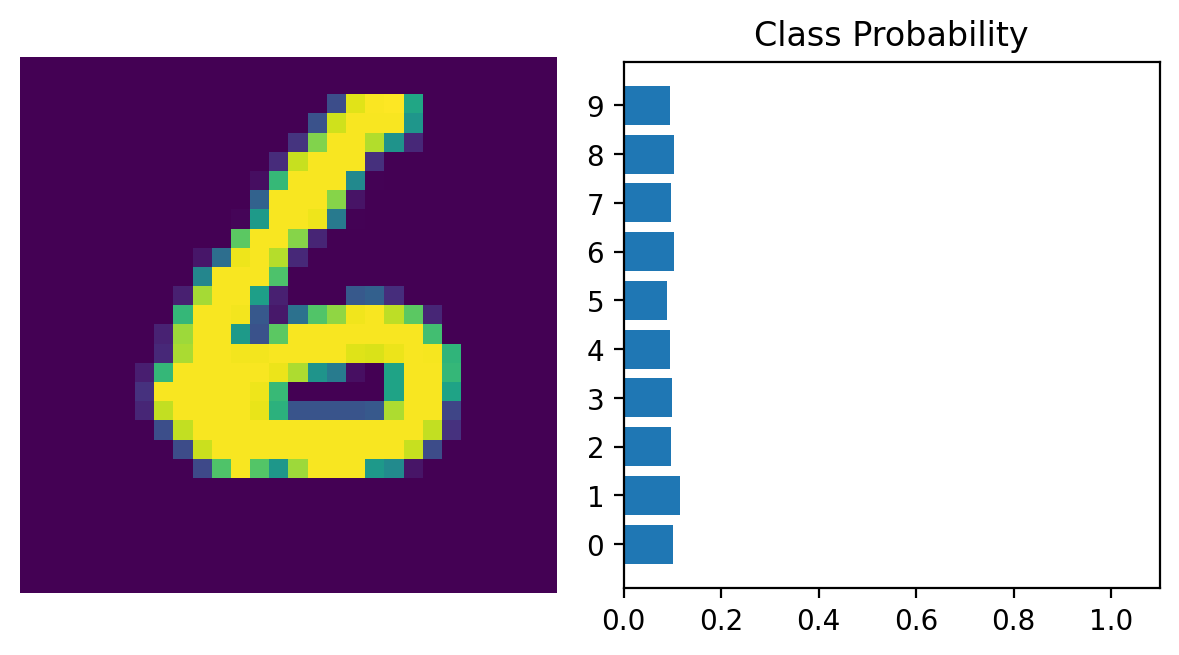

In [97]:
# Возьмем некоторые данные 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Изменим размер изображений на 1D вектор, новая форма (размер пакета, цветовые каналы, пиксели изображения) 
images.resize_(64, 1, 784)
# или images.resize_(images.shape[0], 1, 784), чтобы автоматически получить размер пакета

# Прямой проход через сеть
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

Как вы можете видеть выше, наша сеть не имеет понятия о том, какая цифра. Это потому, что мы еще не обучили ее, все веса случайны.

### Использование `nn.Sequential`

PyTorch предоставляет удобный способ строить сети, где тензор последовательно проходит через операции, `nn.Sequential` ([документация](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Применим этот способ, чтобы построить эквивалентную сеть:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


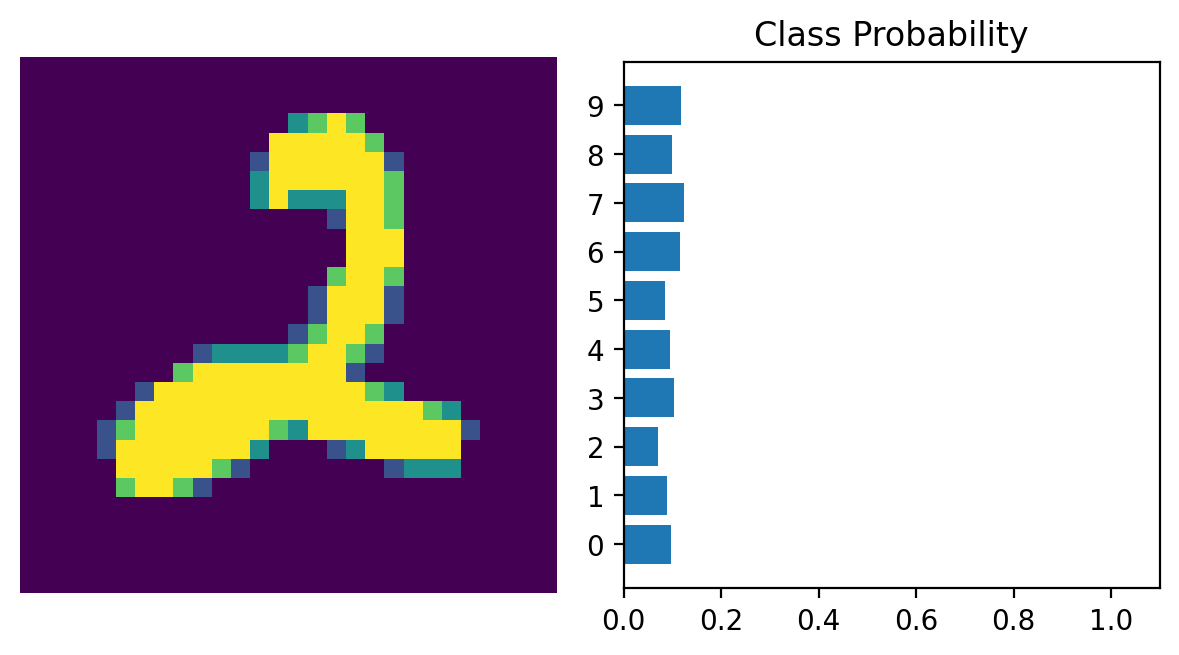

In [98]:
# Гиперпараметры для нашей сети
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Построим сеть
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Прямой проход через сеть и вывод результата
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Операции доступны по соответствующему индексу. Например, если вы хотите получить первую линейную операцию и взглянуть на веса, вы можете использовать `model[0]`.

In [99]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0215, -0.0195,  0.0082,  ...,  0.0004, -0.0027, -0.0182],
        [-0.0258, -0.0229, -0.0226,  ..., -0.0079, -0.0046,  0.0125],
        [ 0.0236,  0.0237,  0.0037,  ...,  0.0137, -0.0166, -0.0304],
        ...,
        [ 0.0050, -0.0290, -0.0026,  ..., -0.0346, -0.0338,  0.0309],
        [ 0.0002,  0.0178, -0.0050,  ...,  0.0099, -0.0083,  0.0061],
        [ 0.0277,  0.0040,  0.0262,  ..., -0.0293,  0.0355,  0.0201]],
       requires_grad=True)

Вы также можете передать `OrderedDict`, чтобы назвать отдельные слои и операции, вместо того, чтобы использовать последовательные целые числа. Обратите внимание, что ключи словаря должны быть уникальными, поэтому _каждая операция должна иметь другое имя_.

In [100]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Теперь вы можете получить доступ к слоям как по индексу, так и по названию.

In [101]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


В следующем блокноте мы увидим, как мы можем обучить нейронную сеть для точного предсказания цифр на изображениях MNIST.